In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/FastAI/

/content/drive/MyDrive/FastAI


In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from models.hex import *

### 1. Table

In [4]:
path = './data/bytes'
files = [f for f in os.listdir(path) if f.endswith('.bytes')]
print("Number of malware data : ", len(files))
data = []
for file_name in files:
    file_path = os.path.join(path, file_name)
    hex_data = read_hex_file(file_path)

    data.append({'Id' : file_name.replace('.bytes', ''), '16_bytes' : hex_data})

data_df = pd.DataFrame(data)
labels_df = pd.read_csv('./data/trainLabels.csv')

# Perform an inner join on the 'Id' column
inner_join_df = pd.merge(data_df, labels_df, on = 'Id', how='inner')
inner_join_df['Size'] = inner_join_df['16_bytes'].apply(len)
inner_join_df.to_csv("./data/malware.csv", index=False)

Number of malware data :  10868


In [5]:
inner_join_df.tail()

,Id,16_bytes,Class,Size
10863,loIP1tiwELF9YNZQjSUO,1000100068341500005058668CC85233D7422BD3100010...,4,912048
10864,LOP6HaJKXpkic5dyuVnT,1000100068AB2900005281C223290B018D94F749100010...,4,155584
10865,LOqA6FX02GWguYrI1Zbe,1000100068FA290000EB296987EB354D9BD1CFF5100010...,4,161528
10866,LoWgaidpb2IUM5ACcSGO,1000100056513AF9BE4EC880008D0D4EC880008B100010...,4,299960
10867,lS0IVqXeJrN6Dzi9Pap1,10001000EB2F6019DEEB42BF8CD5EADB7851B6B7100010...,4,272336


### 2. Data Cleaning

In [3]:
path = './data/malware.csv'
df = pd.read_csv(path)
df.head()

,Id,16_bytes,Class,Size
0,01azqd4InC7m9JpocGv5,00401000E80B000000E916000000909090909090004010...,9,3621312
1,01IsoiSMh5gxyDYTl4CB,00401000C70124045C00E9D64A0000CCCCCCCCCC004010...,2,4723944
2,01jsnpXSAlgw6aPeDxrU,00401000CBCBCBCB0085FFCBFFE8CB7505CB0085004010...,9,3327064
3,01kcPWA9K2BOxQeS5Rju,100010006AFF68A316001064A100000000506489100010...,1,463640
4,01SuzwMJEIXsK7A8dQbl,00401000A4AC4A00AC4F000051EC4800577F4500004010...,8,299424


In [5]:
df.info()
print("Malware mean size : ", df['Size'].mean())
print("16_bytes's width * height : ", np.sqrt(df['Size'].mean()))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10868 entries, 0 to 10867
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Id        10868 non-null  object
 1   16_bytes  10868 non-null  object
 2   Class     10868 non-null  int64 
 3   Size      10868 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 339.8+ KB
Malware mean size :  2229259.980861244
16_bytes's width * height :  1493.0706550130988


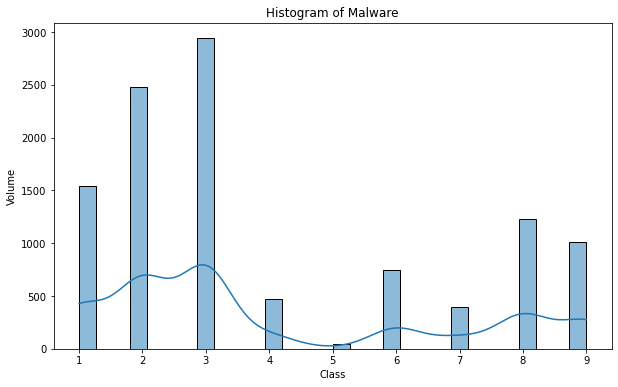

In [12]:
# Histogram of data volume
plt.figure(figsize=(10, 6))
sns.histplot(df['Class'], bins=30, kde=True)
plt.title('Histogram of Malware')
plt.xlabel('Class')
plt.ylabel('Volume')
plt.show()

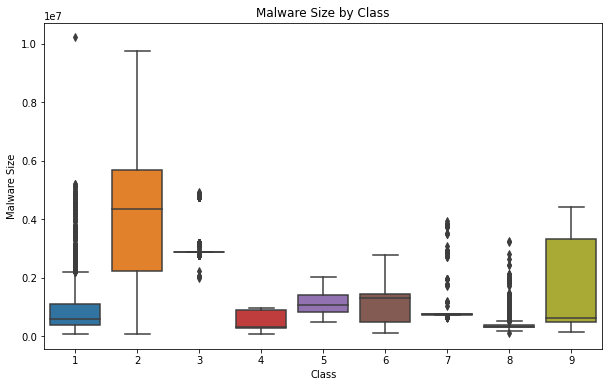

In [6]:
# Box plot of each malware size
plt.figure(figsize=(10, 6))
sns.boxplot(x='Class', y='Size', data=df)
plt.title('Malware Size by Class')
plt.xlabel('Class')
plt.ylabel('Malware Size')
plt.show()

Minimum number of Sampling :  42


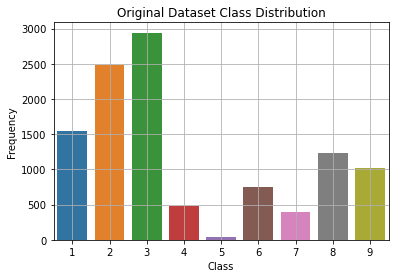

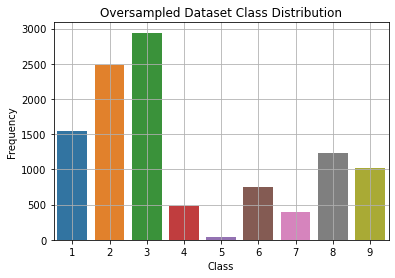

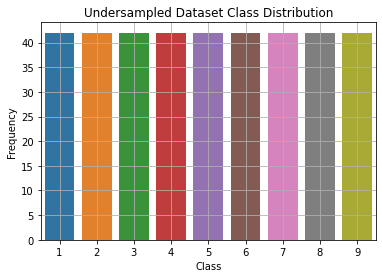

Oversampled data's 16_bytes's width * height :  1493.0706550130988
Undersampled data's 16_bytes's width * height :  1249.996876186573


In [8]:
# Oversampling or Undersampling
class_counts = df['Class'].value_counts()
min_samples = class_counts.min()
#min_samples = class_counts.max()
print("Minimum number of Sampling : ", min_samples)
# Oversampling strategy: Bring up minority classes to the median count
oversampling_strategy = {class_label: int(min_samples) for class_label, count in class_counts.items() if count < min_samples}
# Undersampling strategy: Reduce majority classes to the median count
undersampling_strategy = {class_label: int(min_samples) for class_label, count in class_counts.items() if count > min_samples}

ros = RandomOverSampler(sampling_strategy=oversampling_strategy, random_state=42)
rus = RandomUnderSampler(sampling_strategy=undersampling_strategy, random_state=42)

# Proceed with resampling as before
x_over, y_over = ros.fit_resample(df[['Id','16_bytes', 'Size']], df['Class'])
x_under, y_under = rus.fit_resample(df[['Id','16_bytes', 'Size']], df['Class']) if undersampling_strategy else (df[['Id','16_bytes', 'size']], df['Class'])

oversampled_df = pd.DataFrame(x_over, columns=['Id','16_bytes', 'Size'])
oversampled_df['Class'] = y_over

if undersampling_strategy:
    undersampled_df = pd.DataFrame(x_under, columns=['Id','16_bytes', 'Size'])
    undersampled_df['Class'] = y_under
else:
    undersampled_df = pd.DataFrame([], columns=['Id','16_bytes', 'Size', 'Class'])

# Visualization
def plot_class_distribution(df, title):
    # Count the occurrences of each class
    class_counts = df['Class'].value_counts()

    # Create a bar plot
    sns.barplot(x=class_counts.index, y=class_counts.values)

    plt.title(title)
    plt.xlabel('Class')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

plot_class_distribution(df, 'Original Dataset Class Distribution')
plot_class_distribution(oversampled_df, 'Oversampled Dataset Class Distribution')
plot_class_distribution(undersampled_df, 'Undersampled Dataset Class Distribution')
print("Oversampled data's 16_bytes's width * height : ", np.sqrt(oversampled_df['Size'].mean()))
print("Undersampled data's 16_bytes's width * height : ", np.sqrt(undersampled_df['Size'].mean()))

In [9]:
# Undersampling dataset
undersampled_df.to_csv("./data/under_sample_min.csv", index=False)
undersampled_df.tail()

,Id,16_bytes,Size,Class
373,AyCpqod2kgXKjOnlEbvV,0040100083058880530035568B35208053006A09004010...,3224696,9
374,k8qrhNTAG54fSl6jDtVa,00401000870487FF878700878783008787508787004010...,3306608,9
375,f0NLCiRGpDTU3dlZmSEs,00401000E80B000000E916000000909090909090004010...,611432,9
376,aIpSDAY9T3rsCwV06Xue,0040100040404040404040854040FF560040066A004010...,3327136,9
377,7iEfJHXeGdvRDhx364nL,00401000894DD48D45F0508B4DD4E89F0E00008B004010...,339504,9


In [14]:
# Oversampling dataset
oversampled_df.to_csv("./data/over_sample_max.csv", index=False)
oversampled_df.tail()

,Id,16_bytes,size,Class
26473,4Nxt0uDWz8f6YpPqCTM5,00401000E80B000000E916000000909090909090004010...,3651712,9
26474,6rH4RophlktZL3Cwefbu,00401000ABAB8BABFFABABABABABFF1504515400004010...,3337272,9
26475,cItfpTWOL31m946zFkYs,00401000E80B000000E916000000909090909090004010...,587552,9
26476,g2bUtO0hW3SnQvzClReE,00401000E805000000E90B000000B9058A4300FF004010...,589520,9
26477,d69TJVnLQBqZCIaY2o3E,004010000000D5D5D5D5FF15C020540000FF0075004010...,3306680,9


In [ ]:
# Splitting dataset(Oversampling dataset)
X = oversampled_df.drop('Class', axis=1)
y = oversampled_df['Class']

# indicates that 10% of the data will be set aside for the test set.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

train_df = pd.DataFrame(X_train)
train_df['Class'] = y_train

test_df = pd.DataFrame(X_test)
test_df['Class'] = y_test

print("Training set size:", len(train_df))
print("Testing set size:", len(test_df))

# Save to CSV
train_df.to_csv('./data/train.csv', index=False)
test_df.to_csv('./data/test.csv', index=False)

Training set size: 23830
Testing set size: 2648


### 3. Data Preprocessing

In [ ]:
#path = './data/under_sample_400.csv'
#path = './data/over_sample_max.csv'
#oversampled_df = pd.read_csv(path)
#oversampled_df.tail()
#print("16_bytes's width * height : ", np.sqrt(oversampled_df['size'].mean()))

In [11]:
def convert_image_from_df(df, base_path):

    if not os.path.exists(base_path):
        os.makedirs(base_path)

    for idx, row in df.iterrows():
        # get data and label
        hex_data = row['16_bytes']
        class_label = row['Class']
        img_id = row['Id']

        # convert hex data to image(1024 x 0000)
        img = hex_to_image(hex_data, width=1024)

        # Create directory for the class if it doesn't exist
        class_directory = os.path.join(base_path, str(class_label))
        if not os.path.exists(class_directory):
            os.makedirs(class_directory)

        # Save the image
        img.save(os.path.join(class_directory, f'{img_id}.png'))

In [12]:
# Convert 16_bytes to image
convert_image_from_df(undersampled_df, './data/img/undersample_min')
print("The image data conversion of the Undersampled dataset has been completed.")

#convert_image_from_df(oversampled_df, './data/img/oversample_median')
#print("The image data conversion of the Oversampled dataset has been completed.")

The image data conversion of the Undersampled dataset has been completed.
